# IMPORTS AND READ CSV

In [141]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import yule_walker
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV, GridSearchCV
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM

In [142]:
df_time_series = pd.read_csv('datasets/historical_demand_sum.csv', index_col='time_index')
df_time_series.index = pd.to_datetime(df_time_series.index)
df_time_series.index = df_time_series.asfreq('MS').index
df_time_series.head()

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06


<AxesSubplot: xlabel='time_index'>

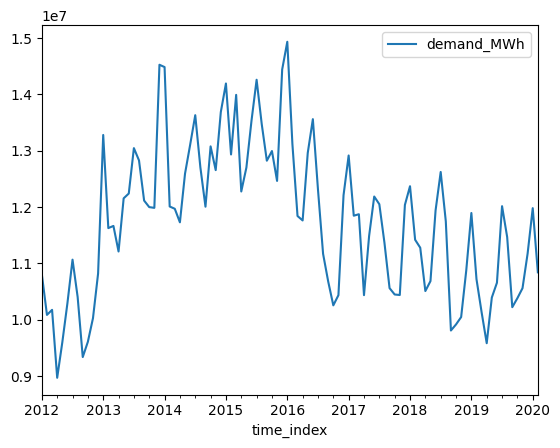

In [143]:
df_time_series.plot()

# CREATE A TIME DUMMY

In [144]:
df_time_series.index.size

98

In [145]:
df_time_series['time_dummy'] = np.arange(df_time_series.index.size)

In [146]:
df_time_series.head()

,demand_MWh,time_dummy
time_index,,
2012-01-01,1.080470e+07,0
2012-02-01,1.008555e+07,1
2012-03-01,1.017537e+07,2
2012-04-01,8.969068e+06,3
2012-05-01,9.597272e+06,4


In [147]:
X = df_time_series[['time_dummy']]
y = df_time_series['demand_MWh']

In [148]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

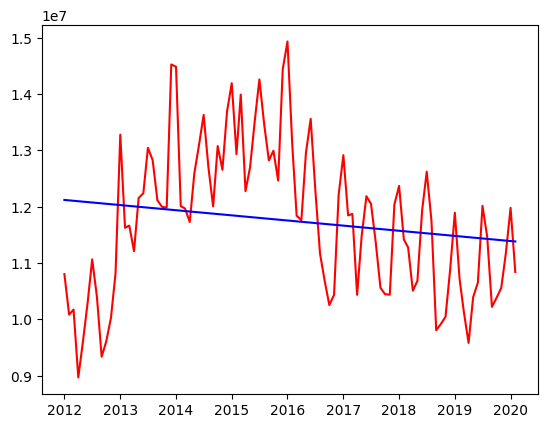

In [149]:

# ax.set_ylabel("Monthly Difference")
plt.plot(df_time_series[['demand_MWh']], c='red')
plt.plot(y_pred, c='blue')
plt.show()

# LAG FEATURE

In [150]:
df_time_series2 = df_time_series.copy()
df_time_series2['demand_MWh_shifted'] = df_time_series2['demand_MWh'].shift(1)
df_time_series2.dropna(inplace=True)

In [151]:
df_time_series2

,demand_MWh,time_dummy,demand_MWh_shifted
time_index,,,
2012-02-01,1.008555e+07,1,1.080470e+07
2012-03-01,1.017537e+07,2,1.008555e+07
2012-04-01,8.969068e+06,3,1.017537e+07
2012-05-01,9.597272e+06,4,8.969068e+06
2012-06-01,1.029218e+07,5,9.597272e+06
...,...,...,...
2019-10-01,1.038260e+07,93,1.022258e+07
2019-11-01,1.055948e+07,94,1.038260e+07
2019-12-01,1.117532e+07,95,1.055948e+07


In [152]:
X = df_time_series2[['demand_MWh_shifted']]
y = df_time_series2['demand_MWh']

In [153]:
X.head()

,demand_MWh_shifted
time_index,
2012-02-01,1.080470e+07
2012-03-01,1.008555e+07
2012-04-01,1.017537e+07
2012-05-01,8.969068e+06
2012-06-01,9.597272e+06


In [154]:
model = LinearRegression()
model.fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

[None,
 Text(0, 0.5, 'sales'),
 Text(0.5, 0, 'demand_MWh_shifted'),
 Text(0.5, 1.0, 'Lag Plot')]

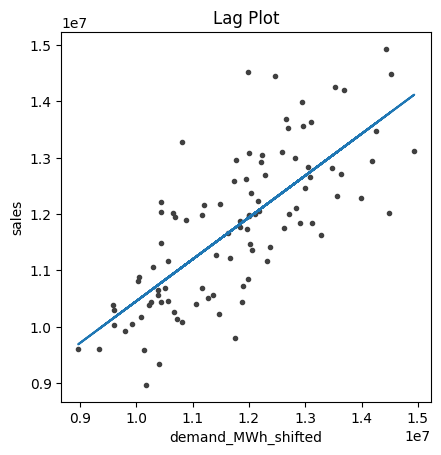

In [155]:
fig, ax = plt.subplots()
ax.plot(X['demand_MWh_shifted'], y, '.', color='0.25')
ax.plot(X['demand_MWh_shifted'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='demand_MWh_shifted', title='Lag Plot')

# TREND

In [156]:
df_time_series3 = df_time_series2.copy()
trend = df_time_series3['demand_MWh'].rolling(
    window=12,
    min_periods=6,
    center=True
).mean()

In [157]:
dp = DeterministicProcess(
    index=df_time_series3.index,     # dates from the training data
    constant=True,                  # dummy feature for the bias (y_intercept)
    order=1,                        # the time dummy (trend)
    drop=True,                      # drop terms if necessary to avoid collinearity
)
X = dp.in_sample()
X.index

DatetimeIndex(['2012-02-01', '2012-03-01', '2012-04-01', '2012-05-01',
               '2012-06-01', '2012-07-01', '2012-08-01', '2012-09-01',
               '2012-10-01', '2012-11-01', '2012-12-01', '2013-01-01',
               '2013-02-01', '2013-03-01', '2013-04-01', '2013-05-01',
               '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01',
               '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01',
               '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01',
               '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01',
               '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01',
               '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01',
               '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01',
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
      

In [158]:
X.head()

,const,trend
time_index,,
2012-02-01,1.0,1.0
2012-03-01,1.0,2.0
2012-04-01,1.0,3.0
2012-05-01,1.0,4.0
2012-06-01,1.0,5.0


In [159]:
# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
# model.predict(X_train).reshape(-1)
y_pred = pd.Series(model.predict(X), index=X.index)

In [160]:
df_time_series['demand_MWh'].size

98

In [161]:
y.head()

time_index
2012-02-01    1.008555e+07
2012-03-01    1.017537e+07
2012-04-01    8.969068e+06
2012-05-01    9.597272e+06
2012-06-01    1.029218e+07
Freq: MS, Name: demand_MWh, dtype: float64

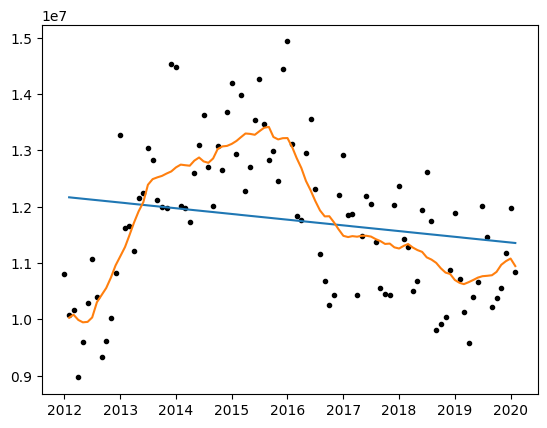

In [162]:
plt.scatter(df_time_series.index, df_time_series['demand_MWh'], c='black', marker='.')
plt.plot(y_pred)
plt.plot(trend)


In [163]:
X = dp.out_of_sample(30)
X.index

DatetimeIndex(['2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [164]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2020-03-01    1.134861e+07
2020-04-01    1.134016e+07
2020-05-01    1.133171e+07
2020-06-01    1.132326e+07
2020-07-01    1.131481e+07
Freq: MS, dtype: float64

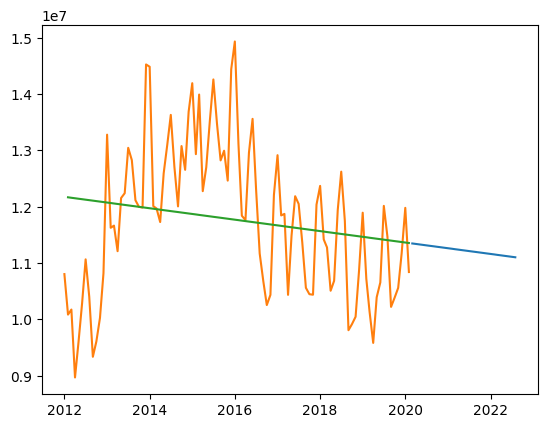

In [165]:
plt.plot(y_fore)
plt.plot(df_time_series['demand_MWh'])
plt.plot(y_pred)

# SEASONALITY

In [166]:
df_time_series.head()

,demand_MWh,time_dummy
time_index,,
2012-01-01,1.080470e+07,0
2012-02-01,1.008555e+07,1
2012-03-01,1.017537e+07,2
2012-04-01,8.969068e+06,3
2012-05-01,9.597272e+06,4


In [167]:
# df_time_series_seasonality = df_time_series.drop(columns=['time_dummy', 'demand_MWh_shifted'])
df_time_series_seasonality = df_time_series.drop(columns=['time_dummy'])
df_time_series_seasonality

,demand_MWh
time_index,
2012-01-01,1.080470e+07
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
...,...
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07
2019-12-01,1.117532e+07


In [168]:
df_time_series_seasonality['month'] = df_time_series_seasonality.index.month
df_time_series_seasonality['year'] = df_time_series_seasonality.index.year
df_time_series_seasonality['four_months_period'] = utils.four_months_period(df_time_series_seasonality)
df_time_series_seasonality['six_months_period'] = utils.six_months_period(df_time_series_seasonality)

In [169]:
y = df_time_series_seasonality['demand_MWh']

The periodogram plot remains pending to be fixed. Data doesn't have weekly frequency

/home/tomas/codes/electric_energy_demand_argentina/utils.py:52: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


<AxesSubplot: title={'center': 'Periodogram'}, ylabel='Variance'>

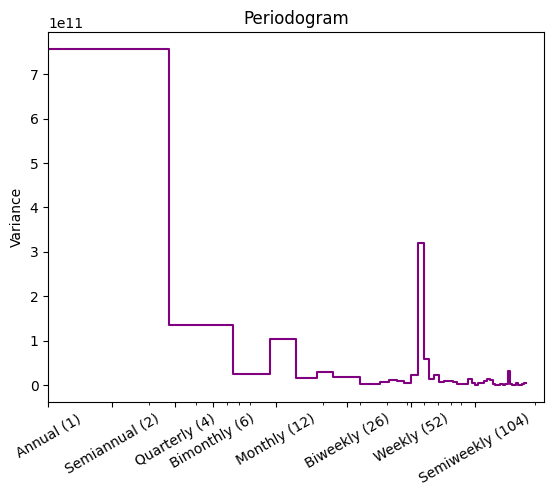

In [170]:
utils.plot_periodogram(df_time_series_seasonality['demand_MWh']) 

In [171]:
fourier = CalendarFourier(freq="A", order=2)
dp = DeterministicProcess(
    index=df_time_series.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()

<AxesSubplot: xlabel='time_index'>

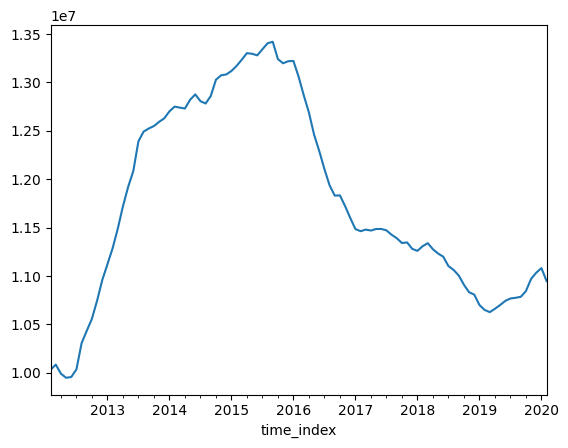

In [172]:
trend.plot()

In [173]:
X.head()

,const,trend,trend_squared,trend_cubed,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,,,,,,,,,,,,
2012-01-01,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000
2012-02-01,1.0,2.0,4.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,3.0,9.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,4.0,16.0,64.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,5.0,25.0,125.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.874481,-0.485060,-0.848351,-0.529434


In [174]:
y.head()

time_index
2012-01-01    1.080470e+07
2012-02-01    1.008555e+07
2012-03-01    1.017537e+07
2012-04-01    8.969068e+06
2012-05-01    9.597272e+06
Freq: MS, Name: demand_MWh, dtype: float64

R2 training: 0.8725521599475758


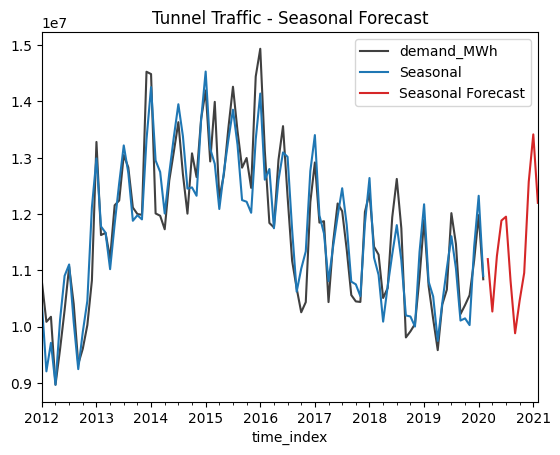

In [175]:

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=12)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()
print(f'R2 training: {r2_score(y, y_pred)}')

/home/tomas/codes/electric_energy_demand_argentina/env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


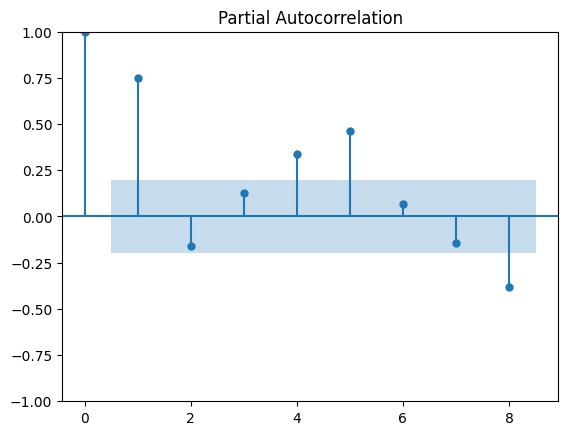

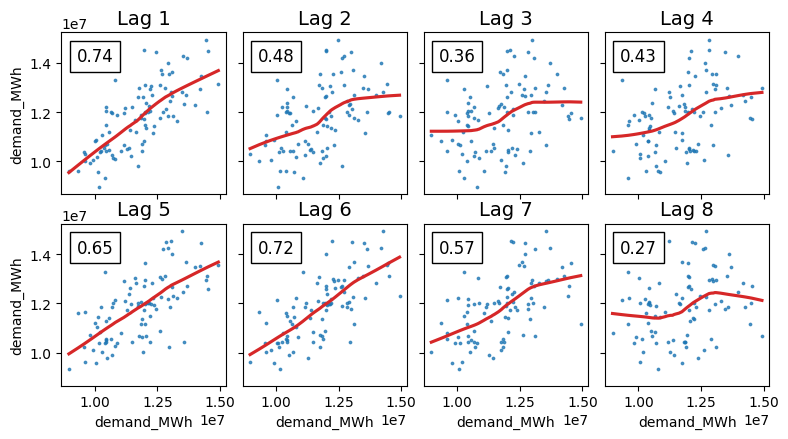

In [176]:
plot_pacf(df_time_series['demand_MWh'], lags=8);
utils.plot_lags(df_time_series['demand_MWh'], lags=8, nrows=2);


# ADDING BUSINESS DAYS AS FEATURE

In [177]:
df_time_series4 = df_time_series.copy()
df_time_series4['demand_MWh_shifted'] = df_time_series4['demand_MWh'].shift(1) 
df_time_series4['demand_MWh_shifted2'] = df_time_series4['demand_MWh_shifted'].shift(1) 
df_time_series4['demand_MWh_shifted3'] = df_time_series4['demand_MWh_shifted2'].shift(1) 
df_time_series4['demand_MWh_shifted4'] = df_time_series4['demand_MWh_shifted3'].shift(1) 
df_time_series4['demand_MWh_shifted5'] = df_time_series4['demand_MWh_shifted4'].shift(1) 
df_time_series4.dropna(inplace=True)

In [178]:
df_time_series4['business_days'] = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in df_time_series4.index]
df_time_series4

,demand_MWh,time_dummy,demand_MWh_shifted,demand_MWh_shifted2,demand_MWh_shifted3,demand_MWh_shifted4,demand_MWh_shifted5,business_days
time_index,,,,,,,,
2012-06-01,1.029218e+07,5,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,1.080470e+07,21
2012-07-01,1.106653e+07,6,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,22
2012-08-01,1.040412e+07,7,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,23
2012-09-01,9.336891e+06,8,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,20
2012-10-01,9.608256e+06,9,9.336891e+06,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,23
...,...,...,...,...,...,...,...,...
2019-10-01,1.038260e+07,93,1.022258e+07,1.146801e+07,1.201620e+07,1.065671e+07,1.039433e+07,23
2019-11-01,1.055948e+07,94,1.038260e+07,1.022258e+07,1.146801e+07,1.201620e+07,1.065671e+07,21
2019-12-01,1.117532e+07,95,1.055948e+07,1.038260e+07,1.022258e+07,1.146801e+07,1.201620e+07,22


In [179]:
y = df_time_series4[['demand_MWh']]
X = df_time_series4.drop(columns=['demand_MWh'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [180]:
y_valid

,demand_MWh
time_index,
2019-03-01,1.013390e+07
2019-04-01,9.582935e+06
2019-05-01,1.039433e+07
2019-06-01,1.065671e+07
2019-07-01,1.201620e+07
2019-08-01,1.146801e+07
2019-09-01,1.022258e+07
2019-10-01,1.038260e+07
2019-11-01,1.055948e+07


In [181]:
model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train, y_train)
forecast_linear_regression = model_linear_regression.predict(X_valid)
series_forecast_linear_regression = pd.DataFrame(forecast_linear_regression, index=y_valid.index, columns=['demand_MWh'])
y_fit = pd.Series(model_linear_regression.predict(X_train).reshape(-1), index=X_train.index)
# y_pred.reshape(-1)

0.7361460434201483


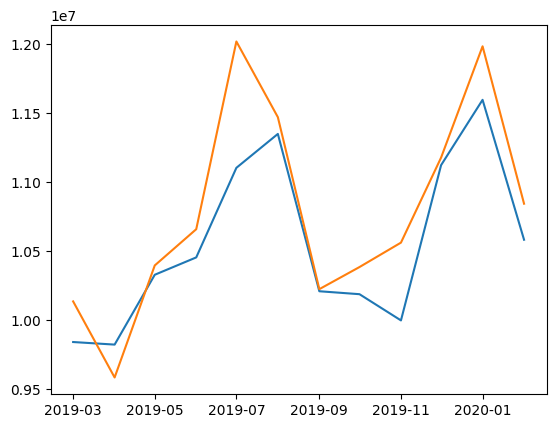

In [182]:
print(r2_score(y_valid, series_forecast_linear_regression))
plt.plot(series_forecast_linear_regression)
plt.plot(y_valid)

In [183]:
X_train

,time_dummy,demand_MWh_shifted,demand_MWh_shifted2,demand_MWh_shifted3,demand_MWh_shifted4,demand_MWh_shifted5,business_days
time_index,,,,,,,
2012-06-01,5,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,1.080470e+07,21
2012-07-01,6,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,1.008555e+07,22
2012-08-01,7,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,1.017537e+07,23
2012-09-01,8,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,8.969068e+06,20
2012-10-01,9,9.336891e+06,1.040412e+07,1.106653e+07,1.029218e+07,9.597272e+06,23
...,...,...,...,...,...,...,...
2018-10-01,81,9.808447e+06,1.174663e+07,1.262365e+07,1.194221e+07,1.068558e+07,23
2018-11-01,82,9.916300e+06,9.808447e+06,1.174663e+07,1.262365e+07,1.194221e+07,22
2018-12-01,83,1.004732e+07,9.916300e+06,9.808447e+06,1.174663e+07,1.262365e+07,21


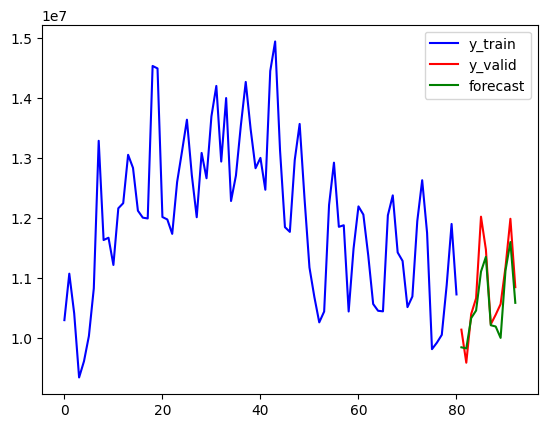

In [184]:
x_ax = np.arange(df_time_series4[['demand_MWh']].size)
plt.plot(x_ax[:(df_time_series4[['demand_MWh']].size-12)], y_train, c='blue', label='y_train')
plt.plot(x_ax[(df_time_series4[['demand_MWh']].size-12):], y_valid, c='red', label='y_valid')
plt.plot(x_ax[(df_time_series4[['demand_MWh']].size-12):], series_forecast_linear_regression, c='green', label='forecast')
plt.legend(loc="upper right")
plt.show()

# HYBRID

In [185]:
df_time_series5 = df_time_series.copy()

df_time_series5['demand_MWh_shifted'] = df_time_series5['demand_MWh'].shift(1)
# df_time_series5['demand_MWh_shifted2'] = df_time_series5['demand_MWh_shifted'].shift(1)
# df_time_series5['demand_MWh_shifted3'] = df_time_series5['demand_MWh_shifted2'].shift(1)
# df_time_series5['demand_MWh_shifted4'] = df_time_series5['demand_MWh_shifted3'].shift(1)
# df_time_series5['demand_MWh_shifted5'] = df_time_series5['demand_MWh_shifted4'].shift(1)
# df_time_series5['demand_MWh_shifted6'] = df_time_series5['demand_MWh_shifted5'].shift(1)
df_time_series5.dropna(inplace=True)
y = df_time_series5[['demand_MWh']]
X = df_time_series5.drop(columns=['demand_MWh'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [186]:
# dp = DeterministicProcess(
#     index=df_time_series5.index,     # dates from the training data
#     constant=True,                  # dummy feature for the bias (y_intercept)
#     order=3,                        # the time dummy (trend)
#     drop=True,                      # drop terms if necessary to avoid collinearity
# )

fourier = CalendarFourier(freq="A", order=2)
dp = DeterministicProcess(
    index=df_time_series5.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=3,                     # trend (order 1 means linear)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)
X = dp.in_sample()
X


,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060
...,...,...,...,...,...,...,...,...
2019-10-01,1.0,93.0,8649.0,804357.0,-0.999917,-0.012910,0.025818,-0.999667
2019-11-01,1.0,94.0,8836.0,830584.0,-0.867456,0.497513,-0.863142,-0.504961
2019-12-01,1.0,95.0,9025.0,857375.0,-0.508671,0.860961,-0.875892,0.482508


In [187]:
# X['six_months_period'] = utils.six_months_period(X.index)
# X["Month"] = X.index.month
# X['business_days'] = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in X.index]

In [188]:
# y = df_time_series[['demand_MWh']]
# X = df_time_series.drop(columns=['demand_MWh'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [189]:
X_train.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060


## LINEAR REGRESSION AND XGBOOST

In [190]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
# y_pred.reshape(-1)
y_fit = pd.Series(model.predict(X_train).reshape(-1), index=X_train.index)
y_pred = pd.Series(model.predict(X_valid).reshape(-1), index=X_valid.index)

r2_score: 0.5927795932816851
mean_absolute_error: 393893.95648452657
mean_absolute_percentage_error: 0.03668534618432017
mean_squared_error: 208220656188.57217
root_mean_squared_error: 456312.01626581367


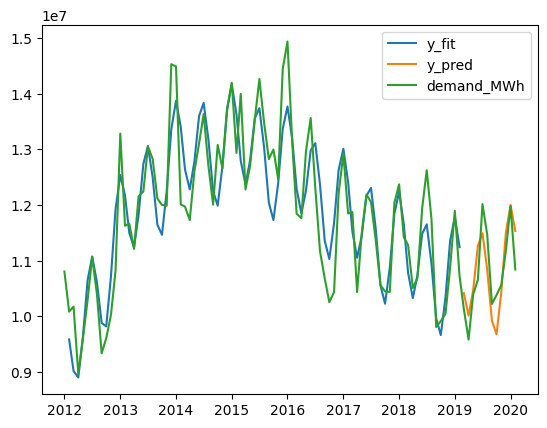

In [191]:
print(f'r2_score: {r2_score(y_valid, y_pred)}')
print(f'mean_absolute_error: {mean_absolute_error(y_valid, y_pred)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(y_valid, y_pred)}')
print(f'mean_squared_error: {mean_squared_error(y_valid, y_pred)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(y_valid, y_pred))}')

plt.plot(y_fit, label='y_fit')
plt.plot(y_pred, label='y_pred')
plt.plot(df_time_series['demand_MWh'], label='demand_MWh')
plt.legend()

In [192]:
X.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
time_index,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060


In [193]:
X['six_months_period'] = utils.six_months_period(X.index)
X["month"] = X.index.month
X['business_days'] = [ np.busday_count(i.date(), (i + pd.DateOffset(months=1)).date()) for i in X.index]
# X['demand_MWh_shifted'] = df_time_series['demand_MWh'].shift(1)
# X.dropna(inplace=True)
X.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)",six_months_period,month,business_days
time_index,,,,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060,1.0,2,21
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977,1.0,3,22
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853,1.0,4,21
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434,1.0,5,23
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060,1.0,6,21


In [194]:
y.head()

,demand_MWh
time_index,
2012-02-01,1.008555e+07
2012-03-01,1.017537e+07
2012-04-01,8.969068e+06
2012-05-01,9.597272e+06
2012-06-01,1.029218e+07


In [195]:
# y2 , X2 = y.align(X, join='outer')
# y2.head()

In [196]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=12)

In [197]:
y_fit = y_fit.squeeze()
y_pred = y_pred.squeeze()
y_train = y_train.squeeze()

In [198]:
y_resid = y_train - y_fit

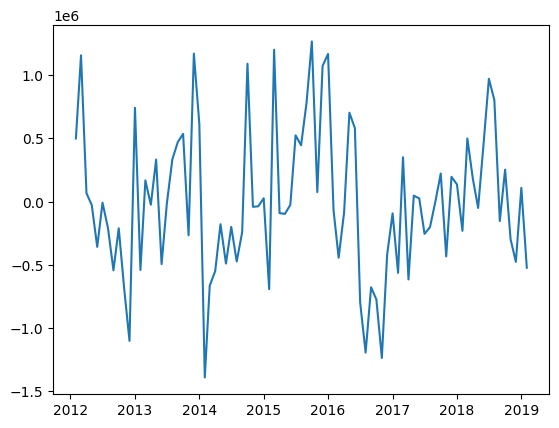

In [199]:
plt.plot(y_resid)

In [200]:
X_train.columns


Index(['const', 'trend', 'trend_squared', 'trend_cubed', 'sin(1,freq=A-DEC)',
       'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)',
       'six_months_period', 'month', 'business_days'],
      dtype='object')

In [201]:
y_resid

time_index
2012-02-01    4.991208e+05
2012-03-01    1.157245e+06
2012-04-01    6.621686e+04
2012-05-01   -2.786959e+04
2012-06-01   -3.587299e+05
                  ...     
2018-10-01    2.525599e+05
2018-11-01   -2.981364e+05
2018-12-01   -4.771342e+05
2019-01-01    1.089407e+05
2019-02-01   -5.235858e+05
Freq: MS, Length: 85, dtype: float64

In [202]:
df_residuals = pd.concat([X_train, y_resid], axis=1)
df_residuals.rename(columns={0: 'residual'}, inplace=True)
df_residuals

,const,trend,trend_squared,trend_cubed,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)",six_months_period,month,business_days,residual
time_index,,,,,,,,,,,,
2012-02-01,1.0,1.0,1.0,1.0,0.507415,0.861702,0.874481,0.485060,1.0,2,21,4.991208e+05
2012-03-01,1.0,2.0,4.0,8.0,0.857315,0.514793,0.882679,-0.469977,1.0,3,22,1.157245e+06
2012-04-01,1.0,3.0,9.0,27.0,0.999963,0.008583,0.017166,-0.999853,1.0,4,21,6.621686e+04
2012-05-01,1.0,4.0,16.0,64.0,0.874481,-0.485060,-0.848351,-0.529434,1.0,5,23,-2.786959e+04
2012-06-01,1.0,5.0,25.0,125.0,0.507415,-0.861702,-0.874481,0.485060,1.0,6,21,-3.587299e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01,1.0,81.0,6561.0,531441.0,-0.999917,-0.012910,0.025818,-0.999667,2.0,10,23,2.525599e+05
2018-11-01,1.0,82.0,6724.0,551368.0,-0.867456,0.497513,-0.863142,-0.504961,2.0,11,22,-2.981364e+05
2018-12-01,1.0,83.0,6889.0,571787.0,-0.508671,0.860961,-0.875892,0.482508,2.0,12,21,-4.771342e+05


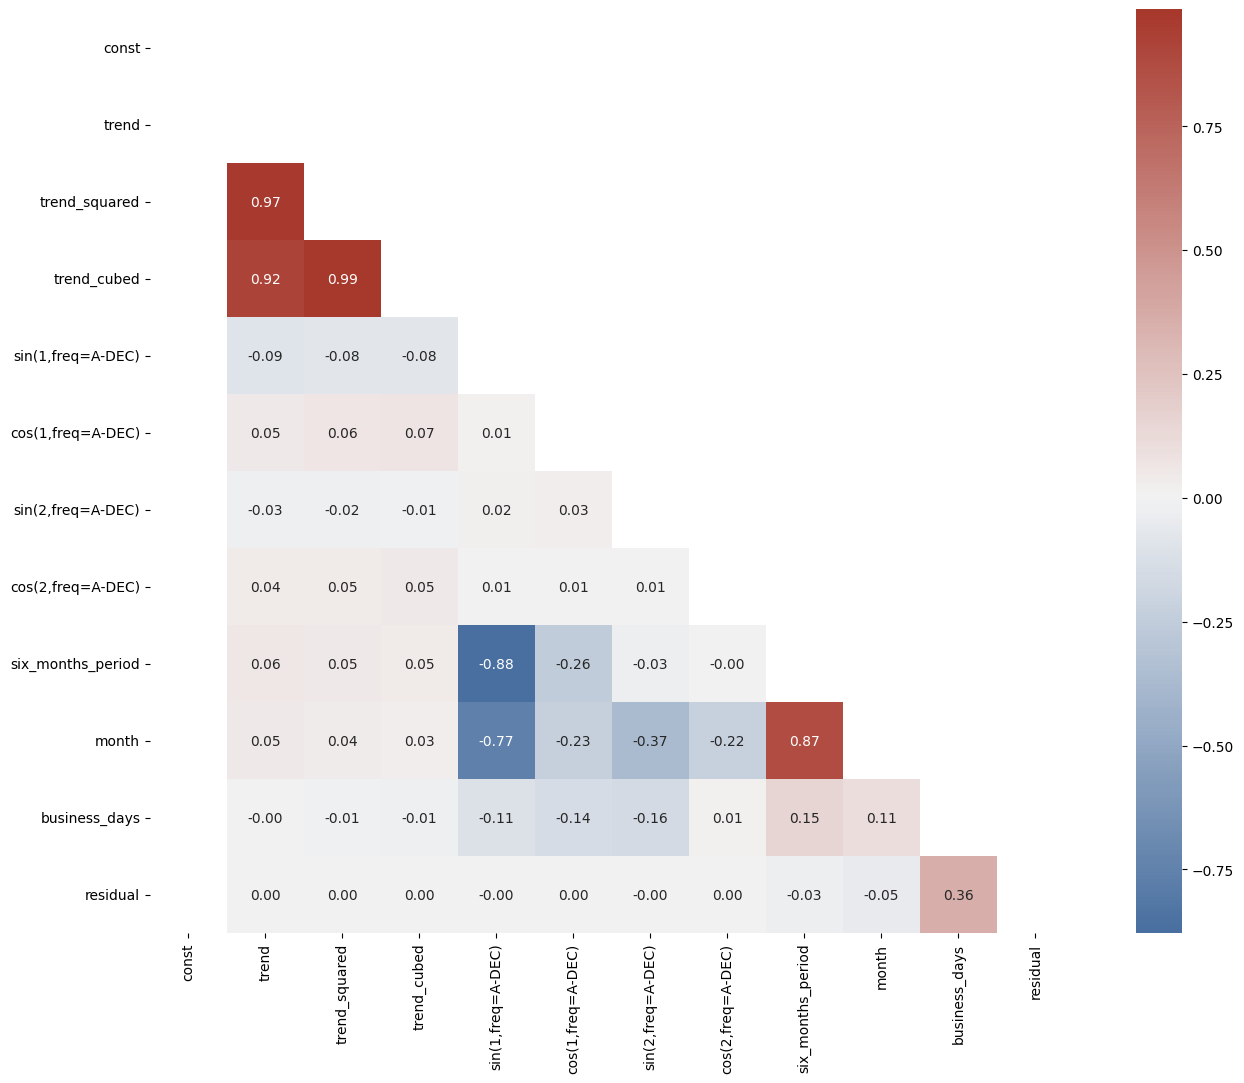

In [203]:
utils.correlation_matrix(df_residuals)

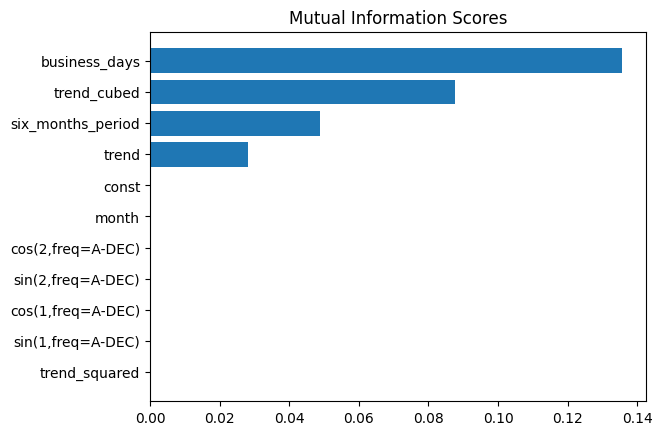

In [204]:
mi_scores = utils.make_mi_scores(X_train, y_resid, 'regression')
utils.plot_scores(mi_scores, 'Mutual Information Scores')

In [205]:
X_train2 = X_train.drop(columns=['sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'const'])
X_valid2 = X_valid.drop(columns=['sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'const'])


In [206]:
# X_train.rename(
#     columns={
#         'sin(1,freq=A-DEC)': 'sin1freqADEC', 
#         'cos(1,freq=A-DEC)': 'cos1freqA-DEC', 
#         'sin(2,freq=A-DEC)': 'sin2freqADEC', 
#         'cos(2,freq=A-DEC)': 'cos2freqA-DEC'
#         },
#         inplace=True)

In [207]:
X_train.columns


Index(['const', 'trend', 'trend_squared', 'trend_cubed', 'sin(1,freq=A-DEC)',
       'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)',
       'six_months_period', 'month', 'business_days'],
      dtype='object')

## RESULTS WITH ALL COLUMNS

In [208]:
model_xgboost = XGBRegressor()
model_xgboost.fit(X_train, y_resid)

y_fit_boosted = model_xgboost.predict(X_train) + y_fit
y_pred_boosted = model_xgboost.predict(X_valid) + y_pred
# series_forecast_xgboost = pd.DataFrame(forecast_xgboost, index=y_valid.index, columns=['demand_MWh'])

r2_score: 0.7907839422268987
mean_absolute_error: 283151.8079498713
mean_absolute_percentage_error: 0.026911501753610224
mean_squared_error: 106976723454.91058
root_mean_squared_error: 327072.96350342163


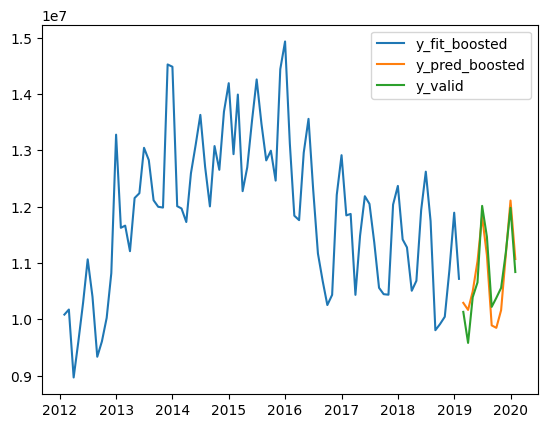

In [209]:
print(f'r2_score: {r2_score(y_valid, y_pred_boosted)}')
print(f'mean_absolute_error: {mean_absolute_error(y_valid, y_pred_boosted)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(y_valid, y_pred_boosted)}')
print(f'mean_squared_error: {mean_squared_error(y_valid, y_pred_boosted)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(y_valid, y_pred_boosted))}')
plt.plot(y_fit_boosted, label='y_fit_boosted')
plt.plot(y_pred_boosted, label='y_pred_boosted')
# plt.plot(y_train, label='y_train')
plt.plot(y_valid, label='y_valid')
plt.legend()

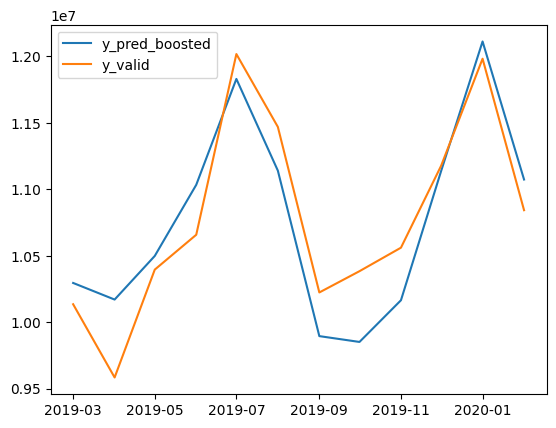

In [210]:
plt.plot(y_pred_boosted, label='y_pred_boosted')
# plt.plot(y_train, label='y_train')
plt.plot(y_valid, label='y_valid')
plt.legend()

## RESULTS DROPPING "INSIGNIFICANT" COLUMNS

In [218]:
model_xgboost = XGBRegressor()
model_xgboost.fit(X_train2, y_resid)

y_fit_boosted = model_xgboost.predict(X_train2) + y_fit
y_pred_boosted = model_xgboost.predict(X_valid2) + y_pred
# series_forecast_xgboost = pd.DataFrame(forecast_xgboost, index=y_valid.index, columns=['demand_MWh'])

r2_score: 0.7219277778770661
mean_absolute_error: 303179.68832096504
mean_absolute_percentage_error: 0.029134500249059295
mean_squared_error: 142184378786.06342
root_mean_squared_error: 377073.43951286655


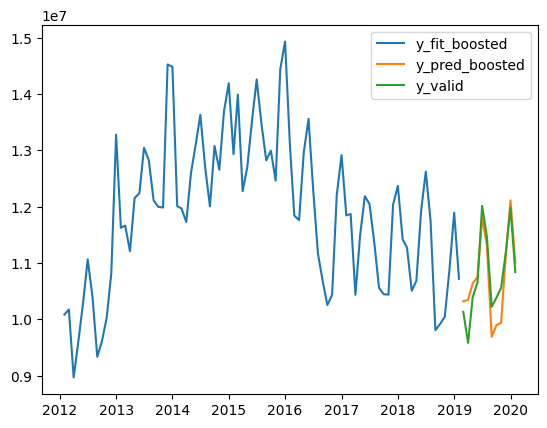

In [219]:
print(f'r2_score: {r2_score(y_valid, y_pred_boosted)}')
print(f'mean_absolute_error: {mean_absolute_error(y_valid, y_pred_boosted)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(y_valid, y_pred_boosted)}')
print(f'mean_squared_error: {mean_squared_error(y_valid, y_pred_boosted)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(y_valid, y_pred_boosted))}')
plt.plot(y_fit_boosted, label='y_fit_boosted')
plt.plot(y_pred_boosted, label='y_pred_boosted')
# plt.plot(y_train, label='y_train')
plt.plot(y_valid, label='y_valid')
plt.legend()

## XGBOOST RANDOMIZEDSEARCHCV

In [221]:
tscv = TimeSeriesSplit(test_size=6, n_splits=2)
for train_index, test_index in tscv.split(X_train):
    print(f'train_index: {train_index}')
    print(f'test_index: {test_index}')

train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
test_index: [73 74 75 76 77 78]
train_index: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78]
test_index: [79 80 81 82 83 84]


In [216]:
xgb_opt = RandomizedSearchCV(
    XGBRegressor(),
    {
        'learning_rate': np.arange(0.1,1.01, 0.01),
        'max_depth': np.arange(1,51),
        'n_estimators' : np.arange(10,1001),
    },
    n_iter=50,
    cv=tscv,
    n_jobs=-1
)

In [222]:
xgb_opt.fit(X_train, y_resid)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=6),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=Non...
        912,  913,  914,  915,  916,  917,  918,  919,  920,  921,  922,
        923,  924,  925,  926,  927,  928,  929,  930,  931,  932,  933,
        934,  935,  936,  937,  938,  939,  940,  941,  942,  943,  944,
        945,  946,  947,  948,  949,  950,  951,  952,  953,  954,  955,
        956,  957,  958,  959,  960,  961,  962,  963,  964,  965,  966,
        967,  968,  969,  970,  971,  972,  973,  974,  975,  976,  977,
        978,  979,  980,  981,  982,  983,  984,  985,  986,  987,  988,
        989,  990,  991,  992,  993,  994,  995,  996,  997,  998,  999,
       1000])})

In [223]:
print(xgb_opt.best_estimator_)
print(xgb_opt.best_score_)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.24999999999999992, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=46, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=957, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)
-2.099772609460219


In [224]:
model_xgboost = xgb_opt.best_estimator_
model_xgboost.fit(X_train2, y_resid)

y_fit_boosted = model_xgboost.predict(X_train2) + y_fit
y_pred_boosted = model_xgboost.predict(X_valid2) + y_pred
# series_forecast_xgboost = pd.DataFrame(forecast_xgboost, index=y_valid.index, columns=['demand_MWh'])

r2_score: 0.7730806930929686
mean_absolute_error: 283542.73454492335
mean_absolute_percentage_error: 0.027048980928223595
mean_squared_error: 116028780008.3694
root_mean_squared_error: 340629.975205309


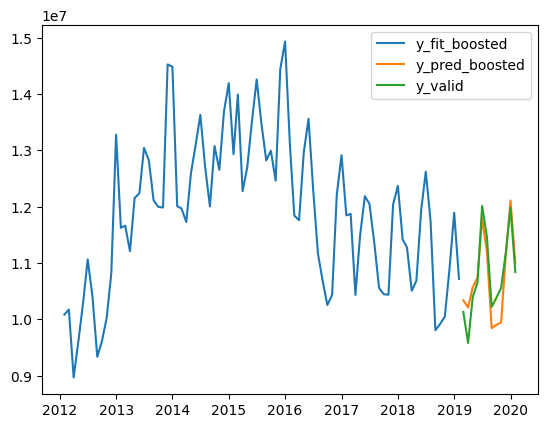

In [225]:
print(f'r2_score: {r2_score(y_valid, y_pred_boosted)}')
print(f'mean_absolute_error: {mean_absolute_error(y_valid, y_pred_boosted)}')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(y_valid, y_pred_boosted)}')
print(f'mean_squared_error: {mean_squared_error(y_valid, y_pred_boosted)}')
print(f'root_mean_squared_error: {np.sqrt(mean_squared_error(y_valid, y_pred_boosted))}')
plt.plot(y_fit_boosted, label='y_fit_boosted')
plt.plot(y_pred_boosted, label='y_pred_boosted')
# plt.plot(y_train, label='y_train')
plt.plot(y_valid, label='y_valid')
plt.legend()